## Importing libraries

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import random as rand
import py21cmfast as p21c

## Cosmological Parameters (Default is used when no input is specified)

In [201]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, etc.

In [202]:
BOX_LEN=300  # Box length
DIM=600      # Number of Voxels for hight resolution 
HII_DIM=300  # Number of Voxels for low resolution 

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,
    DIM=DIM,
    HII_DIM=HII_DIM
)

## Creating initial conditions box

In [203]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Plotting slices of Neutral fractions.

def simple_xH_plot(ion: p21c.outputs.IonizedBox, ax: plt.Axes):
    return ax.imshow(ion.xH_box[:, :, 0].T, extent=(0,200,0,200), vmin=0, vmax=1, origin='lower')

fig, ax = plt.subplots(2, 4, figsize=(14,6), sharex=True, sharey=True, gridspec_kw={"hspace":0.25, 'wspace': 0.05})

for i, z in enumerate([20, 12, 10, 9, 8, 7, 6, 5]):
    ion = p21c.ionize_box(redshift=z, init_boxes=init_cond)
    im = simple_xH_plot(ion, ax.flatten()[i])
    ax.flatten()[i].set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}")
    
cbar = plt.colorbar(im, ax=ax.ravel().tolist())
cbar.set_label("Neutral Fraction")

## Average Neutral Fraction vs. Redshift

lightcone = p21c.run_lightcone(
    redshift = 6,
    max_redshift = 8,
    init_box=init_cond,
    lightcone_quantities=(
        'brightness_temp',
        'xH_box',
    ),
    global_quantities=(
        'brightness_temp',
        'xH_box'
    )
)

p21c.plotting.plot_global_history(lightcone, kind='xH_box')
plt.title("Neutral Freaction vs. Redshift")

## Subject Ionized Box

z=6.5
ionized = p21c.ionize_box(
    redshift=z,
    init_boxes=init_cond
)
subject_box = ionized.xH_box
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond)

## Slice of Subject Box

plt.imshow(subject_box[:, :, 0], origin='lower')
plt.title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}")
plt.colorbar(label="Neutral Fraction")

## Square Blurring Function

In [204]:
def Square_Blurring(box, radius, interation):
    for i in range(interation):
        rand_coord1 = rand.randint(radius, BOX_LEN - 1 - radius)  # ensure that the random center point won't be at the edge of the cube
        rand_coord2 = rand.randint(radius, BOX_LEN - 1 - radius)
        rand_coord3 = rand.randint(radius, BOX_LEN - 1 - radius)

        cube_region = box[rand_coord1-radius:rand_coord1+radius+1, rand_coord2-radius:rand_coord2+radius+1, rand_coord3-radius:rand_coord3+radius+1]
        neutral_mean = np.mean(cube_region)
        box[rand_coord1-radius:rand_coord1+radius+1, rand_coord2-radius:rand_coord2+radius+1, rand_coord3-radius:rand_coord3+radius+1] = neutral_mean
    return box

## Blurring the Subject Box

blurred_box = Square_Blurring(subject_box, 1, 10**7)

## Plotting

In [226]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label="Neutral Fraction")
    plt.sca(last_axes)
    return cbar

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(blurred_box[:, :, 0], origin='lower')
ax1.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
colorbar(img1)

img2 = ax2.imshow(subject_box[:, :, 0], origin='lower')
ax2.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
colorbar(img2)

plt.tight_layout(h_pad=1)

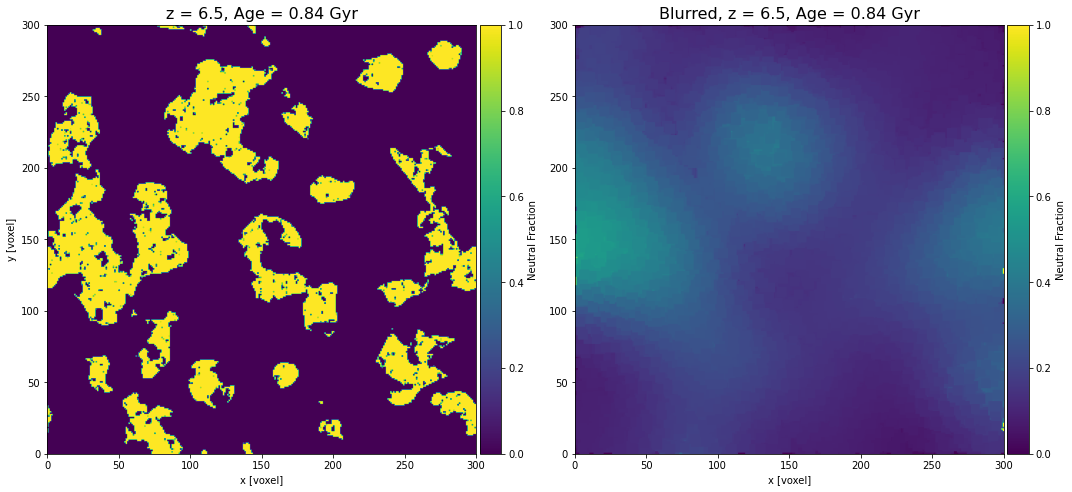

In [242]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Square_Blurring(ionized, 3, 10**7)[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)

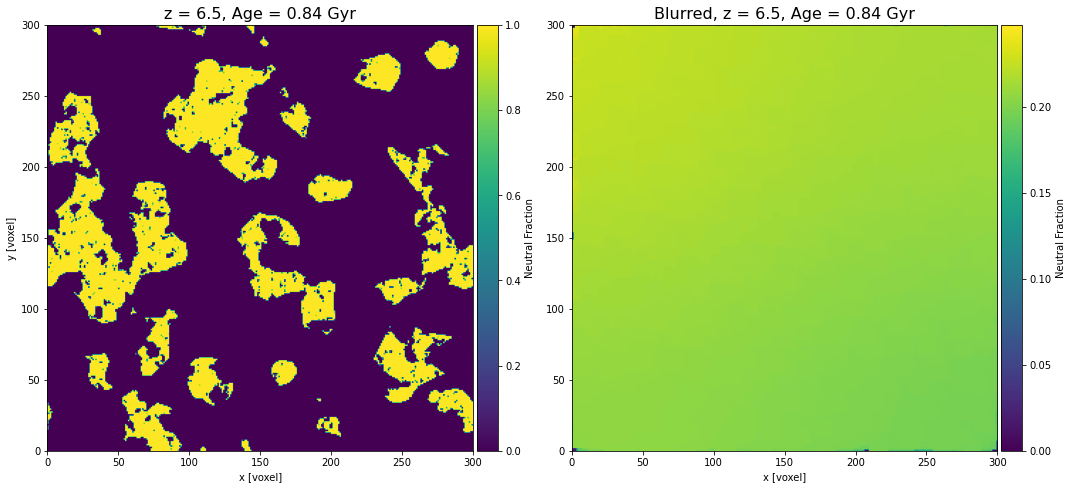

In [245]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Square_Blurring(ionized, 6, 10**7)[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)

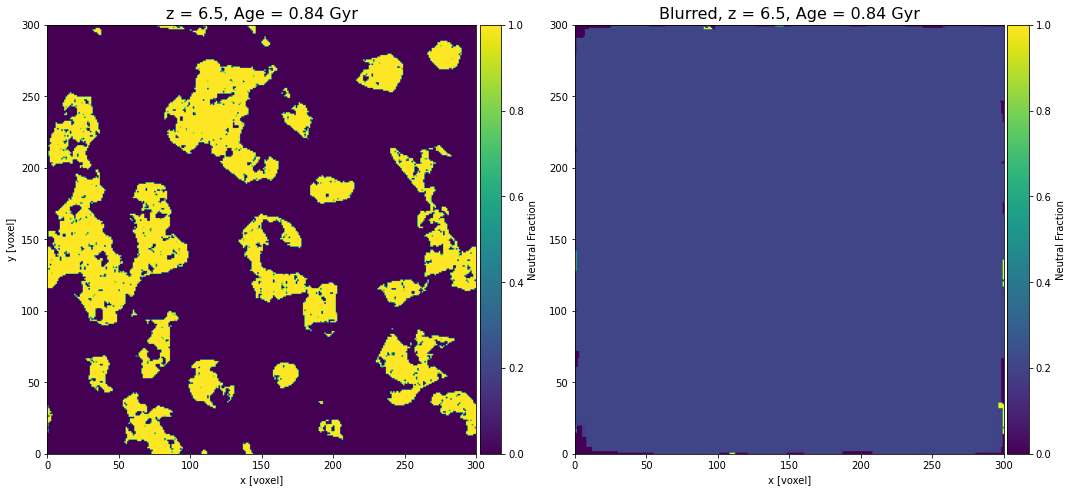

In [246]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Square_Blurring(ionized, 13, 10**6)[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)